In [1]:
gc()
rm(list=ls())

if (!require(pacman)) install.packages("pacman")
library(pacman)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,960177,51.3,1950321,104.2,1249132,66.8
Vcells,1703236,13.0,8388608,64.0,2651364,20.3


Loading required package: pacman



In [2]:
pacman::p_load(tidyverse,
               readxl, 
               chilemapas,
               sjmisc,
               summarytools,
               htmlTable,
               httr,
               texreg,
               chilemapas,
               knitr,
               kableExtra,
               gridExtra,
               stringr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


chilemapas installed



# **Tarea 2**

Profesor José Conejeros

Estudiantes Mario Bravo y Enzo Loiza


## Ejercicio 1

La infección por Hantavirus, cuya mayor expresión de gravedad es el Síndrome Cardiopulmonar (SCPH), es una zoonosis endémica de Chile causada por el virus Andes (ANDV). El ANDV es un virus de genoma ARN segmentado y con envoltura lipídica, miembro del género Orthohantavirus y la familia Hantaviridae. Este virus tiene como reservorio natural el roedor Oligoryzomys longicaudatus conocido como “ratón colilargo o cola larga”, cuyo hábitat se encuentra distribuido desde el valle de Copiapó en la III Región a Campos de Hielo Sur (50° S).

El ministerio de salud le encarga a usted realizar un análisis descriptivo de la situación histórica de los casos de hantavirus y entregar recomendaciones para una mejor atención y control. Para esto usted trabajara con la tabla de datos Hantavirus_chile.xlsx que cuenta con el registro histórico de casos identificados de esta infección. A partir de esto se le pide realizar las siguientes tareas:

a. Importe su tabla de datos e indique cuántas infecciones por Hantavirus se han registrado a la fecha. Explique cuál es la unidad de análisis de estos datos ¿La tabla esta compuesta por personas únicas o hay duplicados? Explique que sería un duplicado en este caso. (0.5 puntos)

In [3]:
db <- read_excel('../input/hantavirus-chile/Hantavirus_chile.xlsx')

In [4]:
head(db)

fecha_notificacion,fecha_primeros_sintomas,sexo,edad_cat,seremi_notificacion,region_residencia,comuna_residencia,cie_10_diagnostico,diagnostico,region_probable_contagio
<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2022-01-07,2021-12-30,hombre,20-24,SEREMI Del Nuble,Region del Nuble,Chillan,B33.4,Síndrome pulmonar por hantavirus,Región del Ñuble
2021-12-30,2021-12-27,hombre,40-44,SEREMI Del Libertador Gral. B. OHiggins,Region del Libertador General Bernardo OHiggins,Pichidegua,B33.4,Síndrome pulmonar por hantavirus,Región del Libertador General Bernardo OHiggins
2021-12-30,2021-12-22,hombre,35-39,SEREMI De Los Lagos,Region de Los Lagos,Los Muermos,B33.4,Síndrome pulmonar por hantavirus,Región de Los Lagos
2021-12-14,2021-12-08,hombre,25-29,SEREMI Del Biobio,Region del Biobio,Mulchen,B33.4,Síndrome pulmonar por hantavirus,Región del Biobío
2021-12-12,2021-12-08,hombre,15-19,SEREMI Del Libertador Gral. B. OHiggins,Region del Libertador General Bernardo OHiggins,Chimbarongo,B33.4,Síndrome pulmonar por hantavirus,Región del Libertador General Bernardo OHiggins
2021-11-25,2021-11-19,hombre,40-44,SEREMI De Los Lagos,Region de Los Lagos,Puerto Montt,B33.4,Síndrome pulmonar por hantavirus,Región de Los Lagos


## Ejercicio 2
En el ejercicio 1 se le pidió realizar una extracción desde la API del Banco Mundial y realizar análisis
a partir de su extracción. En este caso, usted trabajará con la siguiente extracción de la API que
corresponde al ingreso per cápita (GDP) para América Latina y el Caribe solo para el año 2020.


In [5]:
library(WDI)
gdp <- WDI(country = 'all',
          indicator = 'NY.GDP.PCAP.PP.KD',
          start = 2015,
          end = 2020,
          extra = TRUE,
          cache = NULL,
          latest = NULL,
          language = 'es') %>%
    filter(region == 'Latin America & Caribbean' & year == 2020)

Usted debería tener una tabla con las siguientes columnas:

In [6]:
glimpse(gdp)

Rows: 22
Columns: 13
$ country           <chr> "Argentina", "Aruba", "Barbados", "Bolivia", "Chile"…
$ iso2c             <chr> "AR", "AW", "BB", "BO", "CL", "CO", "CR", "CU", "CW"…
$ iso3c             <chr> "ARG", "ABW", "BRB", "BOL", "CHL", "COL", "CRI", "CU…
$ year              <int> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020…
$ NY.GDP.PCAP.PP.KD <dbl> 19685.216, 33155.243, 13805.778, 7679.933, 22970.550…
$ status            <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", …
$ lastupdated       <chr> "2023-07-25", "2023-07-25", "2023-07-25", "2023-07-2…
$ region            <chr> "Latin America & Caribbean", "Latin America & Caribb…
$ capital           <chr> "Buenos Aires", "Oranjestad", "Bridgetown", "La Paz"…
$ longitude         <chr> "-58.4173", "-70.0167", "-59.6105", "-66.1936", "-70…
$ latitude          <chr> "-34.6118", "12.5167", "13.0935", "-13.9908", "-33.4…
$ income            <chr> "Upper middle income", "High income", "High income",…
$ lending          

Además usted sabe que el promedio del GDP para los países en el 2020 es de:

In [7]:
mean(gdp$NY.GDP.PCAP.PP.KD, na.rm = TRUE)

[1] 16154.51

A continuación se realiza el siguiente flujo empaquetado en una función llamada `muestreo`:

In [8]:
muestreo <- function(v, m, n, replace = TRUE){
    library(dplyr)
    library(ggplot2)
    library(patchwork)
    
    vector_promedios <- c()
    for (i in 1:m) {
        muestra <- sample(x = v,
                         size = n,
                         replace = TRUE)
        vector_promedios[i] <- mean(muestra, na.rm = TRUE)
    }

    promedio <- mean(vector_promedios, na.rm = TRUE)

    g1 <- ggplot(data = NULL, aes(x = 1:m, y = vector_promedios)) +
        geom_point(color = "darkblue") + geom_line(color = "blue") +
        geom_hline(yintercept = mean(v, na.rm=TRUE), color = "red", lwd = 1) + #Promedio real
        geom_hline(yintercept = promedio, color = "green", lwd = 1) #Gran media

    g2 <- ggplot(data = NULL, aes(x = vector_promedios)) +
        geom_histogram(bins = 100, fill="darkblue") +
        geom_vline(xintercept = mean(v, na.rm=TRUE), color = "red", lwd = 1) +
        geom_vline(xintercept = promedio, color = "green", lwd = 1)

    grafico <- g1/g2

    print(paste0("Promedios de ", m, " muetras de tamaño ", n, ":"))
    print(vector_promedios)
    print(paste0("Promedio de promedios (Gran media): ", promedio))
    print(paste0("Promedio 'verdadero': ", mean(v, na.rm=TRUE)))
    print(grafico)
}


Utilizando la función `muestreo()` podemos obtener los siguientes resultados:

[1] "Promedios de 200 muetras de tamaño 5:"
  [1] 22869.311 12973.560 19567.843 18521.890 18302.855 17218.954  9198.271
  [8] 20110.912 16612.557 20748.526 14312.530 12314.041 19490.397 19755.081
 [15] 17808.861 18804.328 11221.982 12272.626 19434.686 12392.052 13923.406
 [22] 15785.977 17484.486 16812.588 16126.272 17757.625 12501.131 16679.462
 [29] 14228.990 16148.532 15770.924 14317.477 14639.855 24615.753 11790.575
 [36] 17104.146 17717.759 21611.261  8642.621 10678.583 14462.024 16402.795
 [43] 11145.608  9982.597 20531.278  9790.154 17466.487 19960.669 16783.973
 [50] 20393.131 13400.003 22076.109 19609.325 18164.027 13881.119 14261.744
 [57] 17055.469 14462.484 20098.758 10369.682  8272.883 15736.673 23539.743
 [64] 15320.520 17362.090 21969.280 19651.236 19050.756 16626.515 11842.863
 [71] 21179.089 10675.440 16225.254 16980.711 12558.880 20804.901 21479.105
 [78] 13175.109 20373.801 11214.146 19333.660 12943.548 18401.368 20256.570
 [85]  6617.349 18183.154 11335.177 19387.58

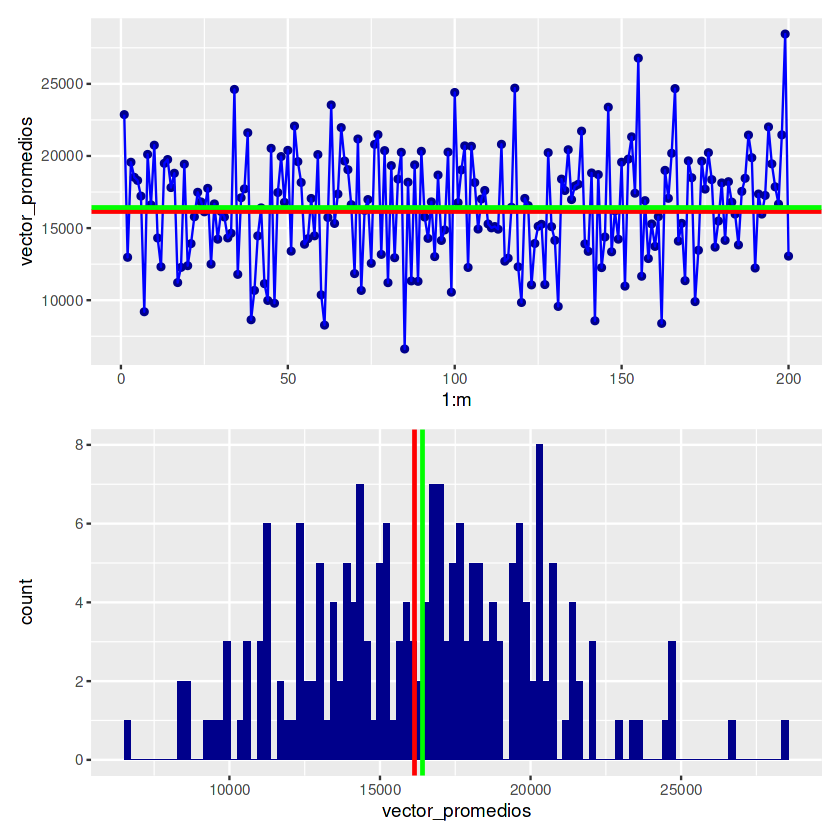

In [9]:
muestreo(v=gdp$NY.GDP.PCAP.PP.KD, m=200, n=5, replace = TRUE)

A partir de la función muestreo() y el análisis detallado resuelva lo siguiente:

a. Describa lo que realiza la función. ¿Cuál es el objetivo de aplicar este proceso sobre los datos? (0.5 puntos)

b. Explique en qué consisten los inputs `v`, `m`, `n` y `replace = TRUE` de la función propuesta. (0.5 puntos)

c. Interprete las dos figuras que se generan a partir de este flujo. (0.5 puntos)

d. ¿En qué se diferencian de forma conceptual la “gran media” de la “media verdadera”? Explique e interprete el resultado obtenido. (0.5 puntos)


## Bonus
Utilizando la tabla de datos `Hantavirus_chile.xlsx`, genere cualquiera de los dos inputs solicitados a continuación (solo 1) y entregue una breve lectura de sus resultados. Sea breve, simple y con un lenguaje directo.

**Input 1**: Gráficos de líneas con la serie temporal para el número de casos de Hantavirus según año-mes. Presente una primera serie general para todos los datos y luego otra figura con las series desagregadas por grupo etario. Utilice la variable fecha_notificacion para construir sus series.

**Input 2**: Realice mapas de Chile con el número de casos de hantavirus por región o comuna (usted decide que es mejor). Estos mapas deben ser desagregados por períodos:

- Un mapa para el número de casos entre 1995 - 2004
- Un mapa para el número de casos entre 2005 - 2014
- Un mapa para el número de casos entre 2015 - 2022

Para esto se puede apoyar de la librería `sf` y `chilemapas`.

